In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from keras_unet_collection import models, base, utils

2023-04-21 23:06:08.263660: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import time
import sys
sys.path.insert(0,'../..')
from gp2 import Runner

2023-04-21 23:06:10.127927: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-21 23:06:10.440122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-21 23:06:10.444222: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-21 23:06:10.444241: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-21 23:06:10.448039: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-21 

In [4]:
R = Runner(verbose=True, classifier='kattunet2d')

*** GP2 ***
Working directory: /tmp/tmp28ziahoqGP2
Verbose mode active!


2023-04-21 23:06:10.521311: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 23:06:10.920569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-21 23:06:10.924539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-21 23:06:10.939966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible 

Model: "attunet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
attunet_down0_0 (Conv2D)        (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
attunet_down0_0_activation (ReL (None, 512, 512, 16) 0           attunet_down0_0[0][0]            
__________________________________________________________________________________________________
attunet_down0_1 (Conv2D)        (None, 512, 512, 16) 2320        attunet_down0_0_activation[0][0] 
______________________________________________________________________________________

In [5]:
# load our larger toy dataset (10k images and masks)
images = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/images.npy')
masks = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/masks.npy')

In [6]:
images = images[:5000]
masks = masks[:5000]

In [7]:
images.shape

(5000, 512, 512, 1)

In [8]:
masks.shape

(5000, 512, 512, 1)

In [9]:
print(images.max())

255


In [10]:
print(images.min())

0


In [11]:
print(masks.max())

True


In [12]:
weights = {
    'A': 0.5,
    'A_train': 0.1,
    'A_val': 0.3,
    'A_test': 0.6,
    'B': 0.3,
    'B_train': 0.7,
    'B_val': 0.1,
    'B_test': 0.2,
    'Z': 0.2
}
PERCENT_TO_REPLACE = 30

In [13]:
R.setup_data(images, masks, dataset_size=5000, weights=weights)

Weights OK!


In [14]:
RUNS = 5

In [15]:
for run in range(RUNS):
    print('***')
    print('RUN:', run)
    t0 = time.time()
    R.run_classifier()
    R.run_discriminator()
    l = R.find_machine_labels()
    if l == 0:
        print('No more machine labels.')
        print('TOOK', time.time()-t0, 'seconds')
        break
    R.relabel(percent_to_replace=PERCENT_TO_REPLACE)
    print('TOOK', time.time()-t0, 'seconds')


***
RUN: 0


2023-04-21 23:06:37.418550: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-21 23:06:37.439048: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245755000 Hz


Epoch 1/100


2023-04-21 23:06:42.506054: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-21 23:06:43.259217: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-21 23:06:43.941450: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-21 23:06:43.941474: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-21 23:06:43.941532: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-21 23:06:43.957343: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-21 23:06:44.723526: I tensorflow/stream_exec

4/4 [==============================] - 52s 8s/step - loss: 0.6679 - dice_coef: 0.1611 - val_loss: 0.6641 - val_dice_coef: 0.1617


2023-04-21 23:07:32.782351: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
4/4 [==============================] - 4s 1s/step - loss: 0.6616 - dice_coef: 0.1603 - val_loss: 0.6582 - val_dice_coef: 0.1609


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/100
4/4 [==============================] - 4s 1s/step - loss: 0.6552 - dice_coef: 0.1595 - val_loss: 0.6526 - val_dice_coef: 0.1602


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/100
4/4 [==============================] - 4s 1s/step - loss: 0.6492 - dice_coef: 0.1587 - val_loss: 0.6468 - val_dice_coef: 0.1596


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/100
4/4 [==============================] - 4s 1s/step - loss: 0.6433 - dice_coef: 0.1582 - val_loss: 0.6411 - val_dice_coef: 0.1592


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/100
4/4 [==============================] - 5s 1s/step - loss: 0.6373 - dice_coef: 0.1575 - val_loss: 0.6357 - val_dice_coef: 0.1589


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/100
4/4 [==============================] - 4s 1s/step - loss: 0.6314 - dice_coef: 0.1575 - val_loss: 0.6302 - val_dice_coef: 0.1586


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/100
4/4 [==============================] - 4s 1s/step - loss: 0.6256 - dice_coef: 0.1571 - val_loss: 0.6247 - val_dice_coef: 0.1585


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/100
4/4 [==============================] - 4s 1s/step - loss: 0.6201 - dice_coef: 0.1569 - val_loss: 0.6195 - val_dice_coef: 0.1583


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/100
4/4 [==============================] - 4s 1s/step - loss: 0.6145 - dice_coef: 0.1569 - val_loss: 0.6140 - val_dice_coef: 0.1582


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/100
4/4 [==============================] - 4s 1s/step - loss: 0.6089 - dice_coef: 0.1566 - val_loss: 0.6088 - val_dice_coef: 0.1581


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/100
4/4 [==============================] - 4s 1s/step - loss: 0.6032 - dice_coef: 0.1566 - val_loss: 0.6035 - val_dice_coef: 0.1580


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/100
4/4 [==============================] - 4s 1s/step - loss: 0.5975 - dice_coef: 0.1563 - val_loss: 0.5977 - val_dice_coef: 0.1579


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/100
4/4 [==============================] - 4s 1s/step - loss: 0.5916 - dice_coef: 0.1564 - val_loss: 0.5923 - val_dice_coef: 0.1578


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/100
4/4 [==============================] - 4s 1s/step - loss: 0.5859 - dice_coef: 0.1563 - val_loss: 0.5870 - val_dice_coef: 0.1577


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/100
4/4 [==============================] - 4s 1s/step - loss: 0.5802 - dice_coef: 0.1560 - val_loss: 0.5813 - val_dice_coef: 0.1576


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/100
4/4 [==============================] - 4s 1s/step - loss: 0.5741 - dice_coef: 0.1560 - val_loss: 0.5756 - val_dice_coef: 0.1574


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/100
4/4 [==============================] - 4s 1s/step - loss: 0.5680 - dice_coef: 0.1552 - val_loss: 0.5697 - val_dice_coef: 0.1573


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/100
4/4 [==============================] - 4s 1s/step - loss: 0.5618 - dice_coef: 0.1556 - val_loss: 0.5635 - val_dice_coef: 0.1572


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/100
4/4 [==============================] - 4s 1s/step - loss: 0.5549 - dice_coef: 0.1554 - val_loss: 0.5569 - val_dice_coef: 0.1571


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/100
4/4 [==============================] - 4s 1s/step - loss: 0.5480 - dice_coef: 0.1555 - val_loss: 0.5499 - val_dice_coef: 0.1569


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/100
4/4 [==============================] - 4s 1s/step - loss: 0.5403 - dice_coef: 0.1553 - val_loss: 0.5419 - val_dice_coef: 0.1568


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 23/100
4/4 [==============================] - 4s 1s/step - loss: 0.5313 - dice_coef: 0.1549 - val_loss: 0.5321 - val_dice_coef: 0.1561


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 24/100
4/4 [==============================] - 4s 1s/step - loss: 0.5202 - dice_coef: 0.1540 - val_loss: 0.5192 - val_dice_coef: 0.1544


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/100
4/4 [==============================] - 4s 1s/step - loss: 0.5046 - dice_coef: 0.1511 - val_loss: 0.4988 - val_dice_coef: 0.1492


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/100
4/4 [==============================] - 4s 1s/step - loss: 0.4791 - dice_coef: 0.1429 - val_loss: 0.4615 - val_dice_coef: 0.1397


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 27/100
4/4 [==============================] - 4s 1s/step - loss: 0.4327 - dice_coef: 0.1358 - val_loss: 0.3944 - val_dice_coef: 0.1464


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 28/100
4/4 [==============================] - 4s 1s/step - loss: 0.3572 - dice_coef: 0.1509 - val_loss: 0.2991 - val_dice_coef: 0.1932


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/100
4/4 [==============================] - 4s 1s/step - loss: 0.3081 - dice_coef: 0.1972 - val_loss: 0.2982 - val_dice_coef: 0.2289


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 30/100
4/4 [==============================] - 4s 1s/step - loss: 0.2730 - dice_coef: 0.2353 - val_loss: 0.2446 - val_dice_coef: 0.2660


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 31/100
4/4 [==============================] - 4s 1s/step - loss: 0.2351 - dice_coef: 0.2776 - val_loss: 0.2217 - val_dice_coef: 0.3014


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 32/100
4/4 [==============================] - 4s 1s/step - loss: 0.2171 - dice_coef: 0.3107 - val_loss: 0.2031 - val_dice_coef: 0.3361


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 33/100
4/4 [==============================] - 4s 1s/step - loss: 0.1984 - dice_coef: 0.3388 - val_loss: 0.1889 - val_dice_coef: 0.3638


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/100
4/4 [==============================] - 4s 1s/step - loss: 0.1849 - dice_coef: 0.3694 - val_loss: 0.1776 - val_dice_coef: 0.3843


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/100
4/4 [==============================] - 4s 1s/step - loss: 0.1744 - dice_coef: 0.3983 - val_loss: 0.1726 - val_dice_coef: 0.3932


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 36/100
4/4 [==============================] - 4s 1s/step - loss: 0.1666 - dice_coef: 0.4156 - val_loss: 0.1595 - val_dice_coef: 0.4372


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 37/100
4/4 [==============================] - 4s 1s/step - loss: 0.1577 - dice_coef: 0.4328 - val_loss: 0.1566 - val_dice_coef: 0.4631


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 38/100
4/4 [==============================] - 4s 1s/step - loss: 0.1531 - dice_coef: 0.4537 - val_loss: 0.1478 - val_dice_coef: 0.4667


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 39/100
4/4 [==============================] - 4s 1s/step - loss: 0.1465 - dice_coef: 0.4790 - val_loss: 0.1446 - val_dice_coef: 0.4737


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 40/100
4/4 [==============================] - 4s 1s/step - loss: 0.1416 - dice_coef: 0.4946 - val_loss: 0.1363 - val_dice_coef: 0.5102


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 41/100
4/4 [==============================] - 4s 1s/step - loss: 0.1338 - dice_coef: 0.5097 - val_loss: 0.1317 - val_dice_coef: 0.5390


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 42/100
4/4 [==============================] - 4s 1s/step - loss: 0.1281 - dice_coef: 0.5363 - val_loss: 0.1249 - val_dice_coef: 0.5531


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 43/100
4/4 [==============================] - 4s 1s/step - loss: 0.1220 - dice_coef: 0.5631 - val_loss: 0.1205 - val_dice_coef: 0.5641


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 44/100
4/4 [==============================] - 5s 1s/step - loss: 0.1164 - dice_coef: 0.5876 - val_loss: 0.1170 - val_dice_coef: 0.5792


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 45/100
4/4 [==============================] - 4s 1s/step - loss: 0.1120 - dice_coef: 0.6147 - val_loss: 0.1193 - val_dice_coef: 0.5806
Epoch 46/100
4/4 [==============================] - 4s 1s/step - loss: 0.1116 - dice_coef: 0.6356 - val_loss: 0.1106 - val_dice_coef: 0.6143


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 47/100
4/4 [==============================] - 4s 1s/step - loss: 0.1075 - dice_coef: 0.6500 - val_loss: 0.1016 - val_dice_coef: 0.6873


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 48/100
4/4 [==============================] - 4s 1s/step - loss: 0.0999 - dice_coef: 0.6627 - val_loss: 0.1053 - val_dice_coef: 0.7076
Epoch 49/100
4/4 [==============================] - 4s 1s/step - loss: 0.0983 - dice_coef: 0.6866 - val_loss: 0.0934 - val_dice_coef: 0.7096


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 50/100
4/4 [==============================] - 4s 1s/step - loss: 0.0920 - dice_coef: 0.7146 - val_loss: 0.0929 - val_dice_coef: 0.6978


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 51/100
4/4 [==============================] - 4s 1s/step - loss: 0.0888 - dice_coef: 0.7217 - val_loss: 0.0888 - val_dice_coef: 0.7211


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 52/100
4/4 [==============================] - 4s 1s/step - loss: 0.0849 - dice_coef: 0.7287 - val_loss: 0.0864 - val_dice_coef: 0.7467


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 53/100
4/4 [==============================] - 5s 1s/step - loss: 0.0827 - dice_coef: 0.7411 - val_loss: 0.0870 - val_dice_coef: 0.7621
Epoch 54/100
4/4 [==============================] - 4s 1s/step - loss: 0.0801 - dice_coef: 0.7511 - val_loss: 0.0829 - val_dice_coef: 0.7674


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 55/100
4/4 [==============================] - 4s 1s/step - loss: 0.0777 - dice_coef: 0.7643 - val_loss: 0.0793 - val_dice_coef: 0.7676


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 56/100
4/4 [==============================] - 4s 1s/step - loss: 0.0743 - dice_coef: 0.7703 - val_loss: 0.0776 - val_dice_coef: 0.7635


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 57/100
4/4 [==============================] - 4s 1s/step - loss: 0.0739 - dice_coef: 0.7731 - val_loss: 0.0766 - val_dice_coef: 0.7881


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 58/100
4/4 [==============================] - 4s 1s/step - loss: 0.0712 - dice_coef: 0.7817 - val_loss: 0.0758 - val_dice_coef: 0.7983


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 59/100
4/4 [==============================] - 4s 1s/step - loss: 0.0776 - dice_coef: 0.7846 - val_loss: 0.0892 - val_dice_coef: 0.7166
Epoch 60/100
4/4 [==============================] - 4s 1s/step - loss: 0.0758 - dice_coef: 0.7772 - val_loss: 0.0754 - val_dice_coef: 0.7572


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model saved to: /tmp/tmp28ziahoqGP2/kattunet_0kattunet_model
History saved to: /tmp/tmp28ziahoqGP2/attunet_history_0.pkl
Testing the classifier...
Model saved to /tmp/tmp28ziahoqGP2/cnnd_0.model
History saved to /tmp/tmp28ziahoqGP2/cnnd_history_0.pickle
Testing the discriminator...
10/10 [==============================] - 0s 19ms/step - loss: 7.9977e-05 - accuracy: 1.0000
Found 165 machine labels.
Machine labels [  1   2   3   4   5   6  10  13  14  15  16  17  18  20  21  22  24  26
  29  30  32  33  34  35  38  39  41  46  48  49  51  53  55  56  58  59
  60  66  67  68  70  71  73  74  75  76  78  81  82  86  89  90  91  92
  93  94  96  99 100 102 103 107 110 112 113 114 115 118 120 121 122 124
 127 128 130 132 134 135 136 138 139 141 143 146 150 154 155 159 160 164
 165 166 167 168 169 171 173 174 175 176 180 182 183 186 189 190 193 195
 196 197 198 201 203 205 206 207 208 209 211 212 214 215 218 226 227 233
 234 236 239 240 242 244 245 246 247 248 250 251 252 253 254 255 258 259


TOOK 3925.911150932312 seconds
***
RUN: 1
Epoch 1/100
5/5 [==============================] - 20s 5s/step - loss: 0.0715 - dice_coef: 0.7794 - val_loss: 0.0732 - val_dice_coef: 0.7659


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
5/5 [==============================] - 5s 1s/step - loss: 0.0667 - dice_coef: 0.7911 - val_loss: 0.0687 - val_dice_coef: 0.7910


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/100
5/5 [==============================] - 5s 1s/step - loss: 0.0636 - dice_coef: 0.7983 - val_loss: 0.0669 - val_dice_coef: 0.7994


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/100
5/5 [==============================] - 5s 1s/step - loss: 0.0621 - dice_coef: 0.8041 - val_loss: 0.0664 - val_dice_coef: 0.8098


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/100
5/5 [==============================] - 5s 1s/step - loss: 0.0608 - dice_coef: 0.8109 - val_loss: 0.0661 - val_dice_coef: 0.8028


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/100
5/5 [==============================] - 5s 1s/step - loss: 0.0599 - dice_coef: 0.8079 - val_loss: 0.0659 - val_dice_coef: 0.8037


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/100
5/5 [==============================] - 5s 1s/step - loss: 0.0598 - dice_coef: 0.8083 - val_loss: 0.0659 - val_dice_coef: 0.8037
Epoch 8/100
5/5 [==============================] - 4s 968ms/step - loss: 0.0597 - dice_coef: 0.8082 - val_loss: 0.0744 - val_dice_coef: 0.7662
Epoch 9/100
5/5 [==============================] - 4s 949ms/step - loss: 0.0819 - dice_coef: 0.7402 - val_loss: 0.1412 - val_dice_coef: 0.6275
Epoch 10/100
5/5 [==============================] - 4s 956ms/step - loss: 0.2241 - dice_coef: 0.5366 - val_loss: 0.2474 - val_dice_coef: 0.5140
Model saved to: /tmp/tmp28ziahoqGP2/kattunet_1kattunet_model
History saved to: /tmp/tmp28ziahoqGP2/attunet_history_1.pkl
Testing the classifier...
Testing the discriminator...
10/10 [==============================] - 0s 21ms/step - loss: 0.2886 - accuracy: 0.9800
Found 146 machine labels.
Machine labels [  3   4   6   7   8  10  13  14  15  16  18  20  21  22  24  25  28  30
  33  34  35  36  37  40  42  43  47  50  52  54  55

TOOK 409.9541349411011 seconds
***
RUN: 2
Epoch 1/100
6/6 [==============================] - 16s 3s/step - loss: 0.1038 - dice_coef: 0.7189 - val_loss: 0.0739 - val_dice_coef: 0.8056


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
6/6 [==============================] - 5s 900ms/step - loss: 0.0952 - dice_coef: 0.7115 - val_loss: 0.0938 - val_dice_coef: 0.6751
Epoch 3/100
6/6 [==============================] - 5s 892ms/step - loss: 0.0924 - dice_coef: 0.7096 - val_loss: 0.0958 - val_dice_coef: 0.6676
Epoch 4/100
6/6 [==============================] - 5s 901ms/step - loss: 0.1708 - dice_coef: 0.5228 - val_loss: 0.2465 - val_dice_coef: 0.4325
Epoch 5/100
6/6 [==============================] - 5s 903ms/step - loss: 0.1980 - dice_coef: 0.4828 - val_loss: 0.1474 - val_dice_coef: 0.5470
Model saved to: /tmp/tmp28ziahoqGP2/kattunet_2kattunet_model
History saved to: /tmp/tmp28ziahoqGP2/attunet_history_2.pkl
Testing the classifier...
Testing the discriminator...
10/10 [==============================] - 0s 22ms/step - loss: 0.0751 - accuracy: 0.9933
Found 160 machine labels.
Machine labels [  7  10  11  14  16  20  24  27  29  31  32  33  34  35  36  37  40  42
  43  46  47  48  49  53  54  57  60  61  62  63  

Removed: 53 Filled: 53
TOOK 170.62059211730957 seconds
***
RUN: 3
Epoch 1/100
7/7 [==============================] - 13s 2s/step - loss: 0.1366 - dice_coef: 0.5607 - val_loss: 0.1350 - val_dice_coef: 0.5647


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
7/7 [==============================] - 5s 823ms/step - loss: 0.1435 - dice_coef: 0.5432 - val_loss: 0.1594 - val_dice_coef: 0.5198
Epoch 3/100
7/7 [==============================] - 5s 780ms/step - loss: 0.1659 - dice_coef: 0.5034 - val_loss: 0.1753 - val_dice_coef: 0.4946
Model saved to: /tmp/tmp28ziahoqGP2/kattunet_3kattunet_model
History saved to: /tmp/tmp28ziahoqGP2/attunet_history_3.pkl
Testing the classifier...
Testing the discriminator...
10/10 [==============================] - 0s 22ms/step - loss: 0.0500 - accuracy: 0.9933
Found 141 machine labels.
Machine labels [  0   3   4   5   8   9  14  15  20  21  23  24  25  27  32  33  36  40
  44  45  46  47  48  51  52  53  56  57  66  67  68  70  71  72  75  76
  78  81  84  86  87  91  94  95  99 101 102 104 105 106 107 108 109 111
 112 115 117 118 119 120 122 127 128 129 130 131 132 133 138 141 147 148
 149 150 152 154 155 161 165 166 167 168 169 170 171 173 176 177 179 180
 182 183 185 191 193 195 197 202 209 213 214

Epoch 1/100
8/8 [==============================] - 9s 1s/step - loss: 0.1777 - dice_coef: 0.4888 - val_loss: 0.1541 - val_dice_coef: 0.5245


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
8/8 [==============================] - 6s 766ms/step - loss: 0.1202 - dice_coef: 0.6043 - val_loss: 0.1059 - val_dice_coef: 0.6309


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/100
8/8 [==============================] - 6s 773ms/step - loss: 0.1168 - dice_coef: 0.5900 - val_loss: 0.1261 - val_dice_coef: 0.5842
Epoch 4/100
8/8 [==============================] - 6s 748ms/step - loss: 0.1066 - dice_coef: 0.6333 - val_loss: 0.1045 - val_dice_coef: 0.6368


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/100
8/8 [==============================] - 6s 786ms/step - loss: 0.1203 - dice_coef: 0.5934 - val_loss: 0.1462 - val_dice_coef: 0.5482
Epoch 6/100
8/8 [==============================] - 6s 746ms/step - loss: 0.1355 - dice_coef: 0.5734 - val_loss: 0.1249 - val_dice_coef: 0.5865
Model saved to: /tmp/tmp28ziahoqGP2/kattunet_4kattunet_model
History saved to: /tmp/tmp28ziahoqGP2/attunet_history_4.pkl
Testing the classifier...
Testing the discriminator...
10/10 [==============================] - 0s 18ms/step - loss: 0.0870 - accuracy: 0.9967
Found 147 machine labels.
Machine labels [  1   3   5  10  11  16  18  21  23  24  25  28  29  31  33  34  36  37
  38  39  40  46  47  51  52  53  54  59  61  62  63  64  65  67  70  72
  73  76  80  82  83  86  87  91  93  94  95  96  98 100 101 103 106 107
 110 112 114 116 117 118 123 126 127 128 129 131 132 135 137 138 139 142
 143 146 147 148 149 150 151 152 153 154 157 160 161 163 167 170 172 176
 179 184 185 186 188 190 192 194 197 203 208

Removed: 49 Filled: 49
TOOK 290.55114698410034 seconds


In [19]:
R.classifier_scores

[[0.07484114915132523, 0.7555961012840271],
 [0.24607715010643005, 0.5113604664802551],
 [0.1471165418624878, 0.5451997518539429],
 [0.17589420080184937, 0.4910578727722168],
 [0.12454362213611603, 0.583988606929779]]

In [20]:
R.discriminator_scores

[[7.997671491466463e-05, 1.0],
 [0.28861314058303833, 0.9800000190734863],
 [0.07512114197015762, 0.9933333396911621],
 [0.049992453306913376, 0.9933333396911621],
 [0.08700104802846909, 0.996666669845581]]

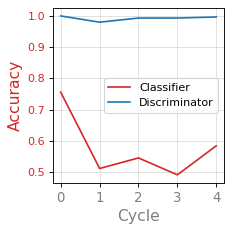

In [18]:
R.plot()

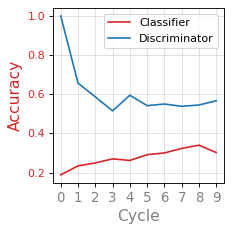

In [18]:
R.plot()

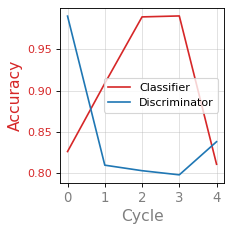

In [17]:
R.plot()